In [2]:
import os
import cv2
import tensorflow as tf
import imageio # convert numpy array to gif
import numpy as np
from matplotlib import pyplot as plt
from typing import List

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

## 1.Build Loading Functions

In [5]:
import gdown # it helps to grab data from google drive

In [6]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet = False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:02<00:00, 185MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [7]:
# now get this into a data loading function
def load_video(path:str) -> List[float]:  # it's gonna take a data path and then it's going to o/p the list of floats which is going to represent our video
   cap = cv2.VideoCapture(path)
   frames = []
   for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): # now we loop through each one of these frames and store it inside of an array called frames
      ret, frame = cap.read()
      frame = tf.image.rgb_to_grayscale(frame)
      frames.append(frame[190:236,80:220,:])
   cap.release()

   mean = tf.math.reduce_mean(frames)
   std = tf.math.reduce_std(tf.cast(frames, tf.float32))
   return tf.cast((frames - mean), tf.float32) / std # we standardize or scale our particular features

Certainly! Here's a more detailed step-by-step explanation of the code:

1. The function `load_video` takes a single argument `path` which represents the path to a video file.

2. Inside the function, `cv2.VideoCapture` is used to create a `cap` object, which is a video capture object provided by the OpenCV library. It opens the video file specified by the `path`.

3. An empty list called `frames` is created. This list will be used to store the video frames.

4. A loop is started that iterates for a number of times equal to the total number of frames in the video. The total number of frames is obtained using `cap.get(cv2.CAP_PROP_FRAME_COUNT)`. The loop will process each frame of the video.

5. Within the loop, `cap.read()` is called to read the next frame from the video. The return value `ret` indicates whether a frame was successfully read, and the actual frame data is stored in the variable `frame`.

6. The `frame` is then converted from RGB to grayscale using the `tf.image.rgb_to_grayscale` function from the TensorFlow library. This converts the frame to a single-channel grayscale representation.

7. A specific region of interest (ROI) is extracted from the frame using array slicing. The syntax `[190:236, 80:220, :]` selects a rectangular region of the frame. The first slice `[190:236]` selects rows 190 to 235, and the second slice `[80:220]` selects columns 80 to 219. The `:` in the last dimension means that all channels are included.

8. The resulting ROI frame is appended to the `frames` list.

9. After the loop finishes processing all frames, the video capture object is released using `cap.release()`. This frees up system resources.

10. The mean value of all frames in the `frames` list is calculated using `tf.math.reduce_mean`. This computes the average value of the frames.

11. The standard deviation of the frames is computed using `tf.math.reduce_std`. The frames are cast to `tf.float32` before calculating the standard deviation.

12. Finally, each frame in the `frames` list is cast to `tf.float32`, subtracted by the mean value computed in step 10, and divided by the standard deviation computed in step 11. This normalizes the frames by subtracting the mean and dividing by the standard deviation. The resulting tensor is returned as the output of the function.

In summary, the code loads a video file, extracts a specific region of interest from each frame, and normalizes the frames by subtracting the mean and dividing by the standard deviation. The normalized frames are then returned as a list of floats representing the video.




The line load_video(path: str) -> List[float]: is a function signature or function declaration. It provides information about the function's name, input parameter, and return type.

Here's a breakdown of the function signature components:

load_video: This is the name of the function. It indicates that the function is intended to load a video.
(path: str): This part represents the input parameter of the function. In this case, path is the name of the parameter, and str specifies that the parameter should be a string data type. It denotes the path to the video file.
-> List[float]: This specifies the return type of the function. List[float] indicates that the function should return a list of float values.
Overall, the function signature load_video(path: str) -> List[float] indicates that the load_video function takes a string parameter path, representing the video file path, and it returns a list of floats representing the video frames.

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [10]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [11]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [12]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [13]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = '/content/data/s1/'+file_name+'.mpg'
    alignment_path = '/content/data/alignments/s1/' + file_name + '.align'
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [14]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [15]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8')

'.\\data\\s1\\bbal6n.mpg'

In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')

['.', 'data', 's1', 'bbal6n.mpg']

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1]

'bbal6n.mpg'

In [18]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')

['bbal6n', 'mpg']

In [19]:
tf.convert_to_tensor(test_path).numpy()

b'.\\data\\s1\\bbal6n.mpg'

In [20]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [21]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.460374  ],
         [ 1.460374  ],
         [ 1.4209044 ],
         ...,
         [ 0.15787826],
         [ 0.19734783],
         [ 0.07893913]],

        [[ 1.460374  ],
         [ 1.460374  ],
         [ 1.4209044 ],
         ...,
         [ 0.15787826],
         [ 0.07893913],
         [ 0.03946957]],

        [[ 1.4209044 ],
         [ 1.4209044 ],
         [ 1.3814349 ],
         ...,
         [ 0.07893913],
         [ 0.07893913],
         [ 0.07893913]],

        ...,

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.946331  ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.906861  ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.906861  ],
         [ 9.86739

In [22]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

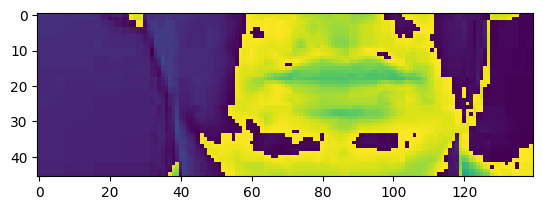

In [23]:
plt.imshow(frames[0]) # grabbing one frame of 0th position

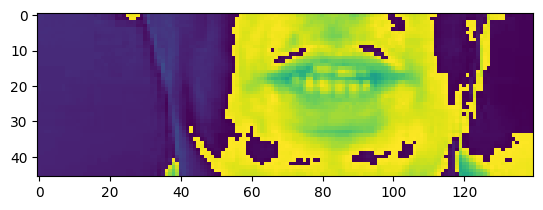

In [24]:
plt.imshow(frames[40])

In [25]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [26]:
num_to_char(alignments.numpy())

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'b', b'i', b'n', b' ', b'b', b'l', b'u', b'e', b' ', b'a', b't',
       b' ', b'l', b' ', b's', b'i', b'x', b' ', b'n', b'o', b'w'],
      dtype=object)>

In [27]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [28]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [29]:
def mappable_function(path:str) -> List[str]:
  result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
  return result

### 2.Create Data Pipeine

In [30]:
from matplotlib import pyplot as plt

In [45]:
data = tf.data.Dataset.list_files('/content/data/s1/*.mpg') # it looks for the files which ends with mpg
data = data.shuffle(500) #we take cache size 500 it will grab first 500 and shuffle those out and return a value out of that
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes = ([75,None,None,None],[40]))# we batching into group sizes of two so each one of these is going to have two videos and two sets of alignments and we're padding our shapes so we're not really going to pad out our videos we are going to ensure that we have 75 frames and we're not going to pad out the actual img itself we just ensure we have 75 frames for each one these videos and we're going to ensure that we have 40 tokens for each one of our alignments if there is less than 40 it's going to be padded out to zero
data = data.prefetch(tf.data.AUTOTUNE)# prefetch it to ensure that we optimize our data pipeline so that we're loading or pre-loading as our ml model is still training

In [47]:
#frames, alignments = data.as_numpy_iterator().next()

In [40]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [41]:
test = data.as_numpy_iterator()

In [54]:
val = test.next(); val[0]

In [57]:
imageio.mimsave('./animated.gif', test[0][1], fps = 10) # we can make gif

### 3. Design the Deep Neural Network

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [60]:
data.as_numpy_iterator().next()[0][0].shape

In [61]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [ ]:
yhat = model.predict(val[0])

In [64]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

In [65]:
model.input_shape

(None, 75, 46, 140, 1)

In [66]:
model.output_shape

(None, 75, 41)

### 4. Setup Training Options and Train

In [67]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [68]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

### 5. Make a Prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [68]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

## Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]